In [2]:
#IMPORT
import pandas as pd
from bs4 import BeautifulSoup
import requests
import os, shutil
from os import listdir
import matplotlib.pyplot as plt

# Functions
Just Run Them       
If you want to run again, you may need to delete folders that created by this script. When folders with same name exists, it raises an error.

In [3]:
# STEP 1: All complexes will be filtered: filter_complexes()
def filter_complexes(resolution_value : float):
    # Find and list all complexes in folder that in samae location with this script
    complex_folder = "CovPDB_complexes"
    cwd = os.path.join(os.getcwd(), complex_folder)

    complexes = [f for f in listdir(cwd)]

    # Create new folder in current directory
    name_newfolder = f"Resolution_{resolution_value}"
    newfolder = os.path.join(os.getcwd(), name_newfolder)

    if not os.path.exists(newfolder):
        os.makedirs(newfolder)
            
    # Seaching and filtering
    count = 0
    all_proteins = {} # Empty list to store protein names as string to use for web scraper

    for protein in complexes: # All index in "complexes" list are also name of the folder and name of the pdb file
        
        protein_folder = os.path.join(cwd, protein) # Directory of parent folder
        pdb_file = os.path.join(protein_folder, f'{protein}.pdb') # Directory of pdb file
        
        with open(pdb_file, 'r') as pdb:
            for line in pdb:
                if 'REMARK   2 RESOLUTION' in line: # Finds resolution line in pdb
                    line = line.split()      
                    try:
                        resolution = float(line[3])     
                        if resolution <= resolution_value:
                            destination_folder = os.path.join(newfolder, protein)
                            shutil.copytree(protein_folder, destination_folder)
                            #print(f'{protein} with the resolution of {resolution} is copied to {destination_folder} ') 
                            count += 1
                            all_proteins[protein] = resolution
                        break  
                    except:
                        #print(f'No resolution data of {protein}')
                        pass

    print(f'>>>> {count} folder filtered <<<<')
    print(f'STEP 1 COMPLETED')

    return all_proteins

In [4]:
# STEP 2: CovPDB search, PDB id search term as name of complex as string: Find_url()
def Find_url(complex_name: str):
    try:
        # URL of the page
        url = 'https://drug-discovery.vm.uni-freiburg.de/covpdb/search/search_type=by_pdb_idsearch_term=' + complex_name

        #  Fetch and parse the HTML content 
        response = requests.get(url)
        html_content = response.content

        soup = BeautifulSoup(html_content, 'html.parser')

        # Find the specific table
        all_tables = soup.find_all('table')
        for table in all_tables:
            thead = table.find('thead')
            if thead and 'Complex(es)' in thead.get_text(): # This is the table we are looking for
                target_table = table
                break

        # Extract URLs from the "SHOW" links
        show_urls = [link['href'] for link in target_table.select('tr.color1 a[href*="complex_card"]')]
        url = "https://drug-discovery.vm.uni-freiburg.de" + show_urls[0] 
        
        print('STEP 2 COMPLETED')
        return url
    except:
        print(f'STEP 2 ERROR: Certain PDB ID cannot be searched on CovPDB database.')
        return 

In [5]:
# STEP 3: Wildcard of the certain complex will be scraped: Data_Scraper()
def Data_Scraper(url : str):
    try:
        # Fetch and parse the HTML content 
        response = requests.get(url)
        html_content = response.text

        soup = BeautifulSoup(html_content, 'html.parser')
        tables = []
        # Find the specific table
        all_tables = soup.find_all('table')
        for table in all_tables:
            thead = table.find('thead')
            if thead and 'Protein' in thead.get_text():
                protein_table = table
                tables.append(protein_table)
            if thead and 'Ligand' in thead.get_text():
                ligand_table = table
                tables.append(ligand_table)
            if thead and 'Covalent Mechanism' in thead.get_text():
                mechanism_table = table
                tables.append(mechanism_table)
    
        print('STEP 3 COMPLETED')
        return tables

    except:
        print('STEP 3 ERROR: Data cannot be scraped.')
        return

In [6]:
# STEP 4: Converting as data frame, Data_Extracter()
def Data_Extracter(tables : list):
    try:    
        # Iterate through rows in the Protein table
        protein_info = {}
        for row in tables[0].select('table.result_table tbody tr'):
            key_cells = row.find_all('td', recursive=False)
            for key_cell in key_cells:
                try:
                    key = key_cell.find('b').get_text(strip=True)
                    anchor_tag = key_cell.find('a')
                    if anchor_tag:
                        value = anchor_tag.get_text(strip=True)
                    else:
                        value = key_cell.get_text(strip=True)
                    key_value_split = value.split(":")
                    if len(key_value_split) > 1:
                        key = key_value_split[0].strip()
                        value = ":".join(key_value_split[1:]).strip()
                        protein_info[key] = value
                    protein_info[key] = value
                except:
                    pass
        protein_df = pd.DataFrame([protein_info.values()], columns=protein_info.keys())

        # Iterate through rows in the Ligand table
        ligand_info = {}
        for row in tables[1].select('tbody tr'):
            key_cells = row.find_all('td', recursive=False)
            for key_cell in key_cells:
                try:
                    key = key_cell.find('b').get_text(strip=True)
                    anchor_tag = key_cell.find('a')
                    if anchor_tag:
                        value = anchor_tag.get_text(strip=True)
                    else:
                        value = key_cell.get_text(strip=True)

                    key_value_split = value.split(":")
                    if len(key_value_split) > 1:
                        key = key_value_split[0].strip()
                        value = ":".join(key_value_split[1:]).strip()
                        protein_info[key] = value
                    ligand_info[key] = value
                except:
                    pass
        
        ligand_df = pd.DataFrame([ligand_info.values()], columns=ligand_info.keys())

        # Iterate through Covalent Mechanism table
        rows = tables[2].find_all('tr')
        headers = tables[2].find_all('thead')[1].find_all('td')
        columns = [header.get_text(strip=True) for header in headers]
        data = []     
        for row in rows:
            cells = row.find_all(['td', 'th'])
            row_data = [cell.get_text(strip=True) for cell in cells]
            data.append(row_data)
        mechanism_df = pd.DataFrame(data, columns=columns)
        mechanism_df = mechanism_df.iloc[[0]]
        mechanism_df = mechanism_df.drop(columns='Warhead Structure', errors='ignore')
        
        result_df = pd.concat([pd.concat([protein_df, ligand_df], axis=1), mechanism_df] , axis=1)

        print('STEP 4 COMPLETED')
        print('Data is added to dataframe')
        return result_df

    except:
        print('STEP 4 ERROR: Data cannot be extracted.')
        return

        

# Filter and Scrap

In [9]:
dataset = pd.DataFrame()
not_collected = []
collected = []
all_proteins = filter_complexes(1.5) #Selects proteins with resolution lower than 1.5

for protein in all_proteins:
    print(f'{protein} data is collecting')
    try:
        proteindata_url = Find_url(protein)
        data = Data_Scraper(proteindata_url)
        information = Data_Extracter(data)
        information = information.rename(index={0: protein}) #Index of data will be changed with protein id


        frames = [dataset,information]
        dataset = pd.concat(frames)

        collected.append(protein)
        print(f'Collected\n')
    except:
        not_collected.append(protein)
        print(f'{protein} data cannot be collected')

#Structure resolution data will be added in order to select bests.
resolution_data = pd.DataFrame(all_proteins.values(),columns=['Structure Resolution'],index=all_proteins.keys())
dataset = dataset.join(resolution_data)

print(f'PROCESS FINISHED')
print(f'{len(collected)} protein collected.\n{len(not_collected)} non-collected proteins: ', not_collected)

>>>> 363 folder filtered <<<<
STEP 1 COMPLETED
4gog data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

2zqc data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

1yqs data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

1pwc data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

4onn data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

6j6m data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

2ce2 data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

6uqs data is collecting
STEP 2 COMPLETED
STEP 3 COMPLETED
STEP 4 COMPLETED
Data is added to dataframe
Collected

1pw8 data is collecting
STEP 2 COMPLETED
STEP 3 C

# Dataset Preparetion

In [8]:
dataset.columns

Index(['Structure Resolution'], dtype='object')

In [8]:
# Some unnecessary or mistaken columns can be dropped
dataset = dataset.drop(columns='(2R,4aR)-11-Chloro-9-fluoro-10-(2-fluoro-6-hydroxyphenyl)-2,6-dimethyl-3-(prop-2-enoyl)-2,3,4,4a-tetrahydro-1H-pyrazino[1′,2′') 

In [10]:
dataset.head()

,Protein Name:,Uniprot ID/ACC:,Organism,Gene Symbol,Gene ID,Protein Class,Ligand Name:,Canonical SMILES,Standard InChI,HET Code:,...,Chain ID,SASA,pKa,Warhead Name,DrugBank,Gene ID:,ChEMBL,PubChem,Uniprot ID/ACC,Structure Resolution
4gog,Beta-lactamase,Q9KJY7 (Q9KJY7_KLEPN),Klebsiella pneumoniae,ges1,-,HYDROLASE,Imipenem,C[C@@H](O)[C@@H]1[C@H]2CC(SCCNC=N)=C(N2C1=O)C(...,InChI=1S/C12H17N3O4S/c1-6(16)9-7-4-8(20-3-2-14...,IM2,...,A,15.16,-,Beta-Lactam,NaN,NaN,NaN,NaN,NaN,1.10
2zqc,Beta-lactamase Toho-1,Q47066 (BLT1_ECOLX),Escherichia coli,bla,-,HYDROLASE,Aztreonam,C[C@H]1[C@H](NC(=O)C(=N/OC(C)(C)C(O)=O)\c2csc(...,"InChI=1S/C13H17N5O8S2/c1-5-7(10(20)18(5)28(23,...",AZR,...,A,10.53,-,Beta-Lactam,NaN,NaN,NaN,NaN,NaN,1.07
1yqs,D-alanyl-D-alanine carboxypeptidase,P15555 (DAC_STRSR),Streptomyces sp. (strain R61),-,-,HYDROLASE,N-benzoyl-beta-sultam,O=S1(=O)CCN1C(=O)c2ccccc2,InChI=1S/C9H9NO3S/c11-9(8-4-2-1-3-5-8)10-6-7-1...,BSA,...,A,12.91,-,Beta-Sultam,-,NaN,NaN,NaN,NaN,1.05
1pwc,D-alanyl-D-alanine carboxypeptidase,P15555 (DAC_STRSR),Streptomyces sp. (strain R61),-,-,HYDROLASE,PENICILLIN G,CC1(C)S[C@@H]2[C@H](NC(=O)Cc3ccccc3)C(=O)N2[C@...,InChI=1S/C16H18N2O4S/c1-16(2)12(15(21)22)18-13...,PNM,...,A,18.11,-,Beta-Lactam,NaN,NaN,NaN,NaN,NaN,1.10
4onn,Ubiquitin-conjugating enzyme E2 N,P61088 (UBE2N_HUMAN),Homo sapiens (Human),UBE2N,NaN,LIGASE,BAY 11-7082,Cc1ccc(cc1)S(=O)(=O)/C=C/C#N,"InChI=1S/C10H9NO2S/c1-9-3-5-10(6-4-9)14(12,13)...",BY1,...,B,43.4,10.71,Beta-Sulfonylvinyl Nitrile,-,7334,NaN,NaN,NaN,1.50


In [ ]:
dataset.to_csv('Dataset_full.csv')
dataset.to_excel('Dataset_full.xlsx')

In [11]:
unique_count = dataset['Reaction Name'].nunique()

print("Number of unique values in 'Reaction Name':", unique_count)

name_counts = dataset['Reaction Name'].value_counts()

print("Count of each unique name:")
print(name_counts)

Number of unique values in 'Reaction Name': 20
Count of each unique name:
Reaction Name
Beta-Lactam Addition                      47
Borylation                                43
Michael Addition                          41
Hemi(thio)acetalization                   32
Nucleophilic Aliphatic Subsititution      29
Nucleophilic Addition to a Triple Bond    26
Imidazolidinone Opening                   21
Nucleophilic Acyl Substitution            17
Epoxide Opening                           16
Phosphorylation                           15
Ring Opening                              12
Disulfide Formation                       12
Nucleophilic Aromatic Substitution        11
Imine Condensation                         9
Sulfonylation                              8
Lactone Addition                           5
Hemiaminalization                          5
Nucleophilic Addition to a Double Bond     3
Composite Reaction                         3
Aziridine Opening                          3
Name: count,

In [12]:
def top_two_resolutions(group):
    return group.sort_values('Structure Resolution', ascending=True).head(2)

# Group by 'Reaction Name' and apply the top_two_resolutions function
highest_res_samples = dataset.groupby('Reaction Name').apply(top_two_resolutions)

print("Top two highest resolution samples for each reaction type:")
highest_res_samples.head(6)


Top two highest resolution samples for each reaction type:


Protein Name:  \
Reaction Name                                                                  
Aziridine Opening    2gke                          Diaminopimelate epimerase   
                     6sxv  Intracellular exo-alpha-(1->5)-L-arabinofurano...   
Beta-Lactam Addition 2zqa                              Beta-lactamase Toho-1   
                     5a92                            Beta-lactamase CTX-M-97   
Borylation           4ua9                                     Beta-lactamase   
                     1m40                                 Beta-lactamase TEM   

                                 Uniprot ID/ACC:  \
Reaction Name                                      
Aziridine Opening    2gke    P44859 (DAPF_HAEIN)   
                     6sxv    Q9XBQ3 (IABF_GEOSE)   
Beta-Lactam Addition 2zqa    Q47066 (BLT1_ECOLX)   
                     5a92   E1ANH6 (BLC97_ECOLX)   
Borylation           4ua9  H6UQI0 (H6UQI0_ECOLX)   
                     1m40    P62593 (BLAT_ECOLX)   

                                                                    Organism  \
Reaction Name                                                                  
Aziridine Opening    2gke  Haemophilus influenzae (strain ATCC 51907 / DS...   
                     6sxv  Geobacillus stearothermophilus (Bacillus stear...   
Beta-Lactam Addition 2zqa                                   Escherichia coli   
                     5a92                                   Escherichia coli   
Borylation           4ua9                                   Escherichia coli   
                     1m40                                   Escherichia coli   

                          Gene Symbol Gene ID Protein Class  \
Reaction Name                                                 
Aziridine Opening    2gke        dapF       -     ISOMERASE   
                     6sxv        abfA       -     HYDROLASE   
Beta-Lactam Addition 2zqa         bla       -     HYDROLASE   
                     5a92         bla       -     HYDROLASE   
Borylation           4ua9      CTXM14       -     HYDROLASE   
                     1m40         bla     NaN     HYDROLASE   

                                                       Ligand Name:  \
Reaction Name                                                         
Aziridine Opening    2gke                                 LL-AziDAP   
                     6sxv  Alpha-L-arabino-cyclophellitol aziridine   
Beta-Lactam Addition 2zqa                                cefotaxime   
                     5a92                                cefotaxime   
Borylation           4ua9                                      LP06   
                     1m40                                      LP06   

                                                            Canonical SMILES  \
Reaction Name                                                                  
Aziridine Opening    2gke                 N[C@@H](CCC[C@]1(CN1)C(O)=O)C(O)=O   
                     6sxv              OC[C@@H]1[C@H]2N[C@H]2[C@H](O)[C@H]1O   
Beta-Lactam Addition 2zqa  CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(COC(C)=O)=C(N2C1...   
                     5a92  CO\N=C(\C(=O)N[C@H]1[C@H]2SCC(COC(C)=O)=C(N2C1...   
Borylation           4ua9        CC(C)(O\N=C(\C(=O)NCB(O)O)c1csc(N)n1)C(O)=O   
                     1m40        CC(C)(O\N=C(\C(=O)NCB(O)O)c1csc(N)n1)C(O)=O   

                                                              Standard InChI  \
Reaction Name                                                                  
Aziridine Opening    2gke  InChI=1S/C8H14N2O4/c9-5(6(11)12)2-1-3-8(4-10-8...   
                     6sxv  InChI=1S/C6H11NO3/c8-1-2-3-4(7-3)6(10)5(2)9/h2...   
Beta-Lactam Addition 2zqa  InChI=1S/C16H17N5O7S2/c1-6(22)28-3-7-4-29-14-1...   
                     5a92  InChI=1S/C16H17N5O7S2/c1-6(22)28-3-7-4-29-14-1...   
Borylation           4ua9  InChI=1S/C10H15BN4O6S/c1-10(2,8(17)18)21-15-6(...   
                     1m40  InChI=1S/C10H15BN4O6S/c1-10(2,8(17)18)21-15-6(...   

        

In [14]:
highest_res_samples.to_csv('Dataset.csv')
highest_res_samples.to_excel('Dataset.xlsx')

In [13]:
# Copies the files of highest_res_samples proteins into new folder 
resolution = 1.5
filtered_file_name = "Resolution_"+str(resolution)
filtered_file = os.path.join(os.getcwd(), filtered_file_name)

complexes = [f for f in listdir(filtered_file)]

# Create new folder in current directory
name_newfolder = "Dataset"
newfolder = os.path.join(os.getcwd(), name_newfolder)
count = 0
if not os.path.exists(newfolder):
    os.makedirs(newfolder)

for selected_protein in highest_res_samples.index:
    # Creates Folder for reaction type
    reaction_type = selected_protein[0]
    reaction_folder = os.path.join(newfolder, reaction_type)
    if not os.path.exists(reaction_folder):
        os.makedirs(reaction_folder)
    
    # Adds selected proteins to reaction folder
    for filtered_protein in complexes:
        if filtered_protein == selected_protein[1]:
            destination_folder = os.path.join(reaction_folder, selected_protein[1])
            source_folder = os.path.join(filtered_file, selected_protein[1])
            shutil.copytree(source_folder, destination_folder)
            

            files = [f for f in listdir(destination_folder)]
            ligand_name =f'{ highest_res_samples.loc[(reaction_type, selected_protein[1]), 'Ligand Name:'] }.sdf'

            # Full path for old and new file names
            old_file_path = os.path.join(destination_folder, files[0])
            new_file_path = os.path.join(destination_folder, ligand_name)
            # Renaming the file
            os.rename(old_file_path, new_file_path)

            count += 1

            

print(f'{count} of {len(highest_res_samples)} Dataset Structure Complexes are Copied Succesfully.')
            

40 of 40 Dataset Structure Complexes are Copied Succesfully.


In [41]:
# Path to the directory containing the file


directory = '/home/ruzgar/Desktop/Filter_n_Scrap-CovPDBcomplexes-main/CovPDB_complexes/2gke'

files = [f for f in listdir(directory)]
print(files)

highest_res_samples.loc[('Aziridine Opening', '2gke'), 'Ligand Name:']

['COVPDB1502.sdf', '2gke.pdb']


'LL-AziDAP'

In [43]:
highest_res_samples['Ligand Name:']

Reaction Name                               
Aziridine Opening                       2gke                                            LL-AziDAP
                                        6sxv             Alpha-L-arabino-cyclophellitol aziridine
Beta-Lactam Addition                    2zqa                                           cefotaxime
                                        5a92                                           cefotaxime
Borylation                              4ua9                                                 LP06
                                        1m40                                                 LP06
Composite Reaction                      2qxi               Suc-Ala-Ala-Pro-Phe-chloromethylketone
                                        5el1                                      (2E)-BUT-2-ENAL
Disulfide Formation                     6hmt    2-(4-chlorophenoxy)-N-(2-{[2-(dimethylamino)et...
                                        6hmu    2-(4-chlorophenoxy)-N-(3-

# Virtualize Dataset

In [ ]:
# Function to plot the count of specific values in each column
values_to_plot = ['Reaction Name','Warhead Name','Protein Class','Residue']
def plot_value_counts(df, values_to_plot):
    for column in df.columns:
        if column in values_to_plot:
            plt.figure(figsize=(10, 6))
            if column == 'Residue':
                df[column].str.split().str[0].value_counts().sort_index().plot(kind='bar')
            else:
                df[column].value_counts().sort_index().plot(kind='bar')
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.show()

print("Distrubiton Plots for Full Dataset")
plot_value_counts(dataset, values_to_plot)

Distrubiton Plots for Selected Dataset


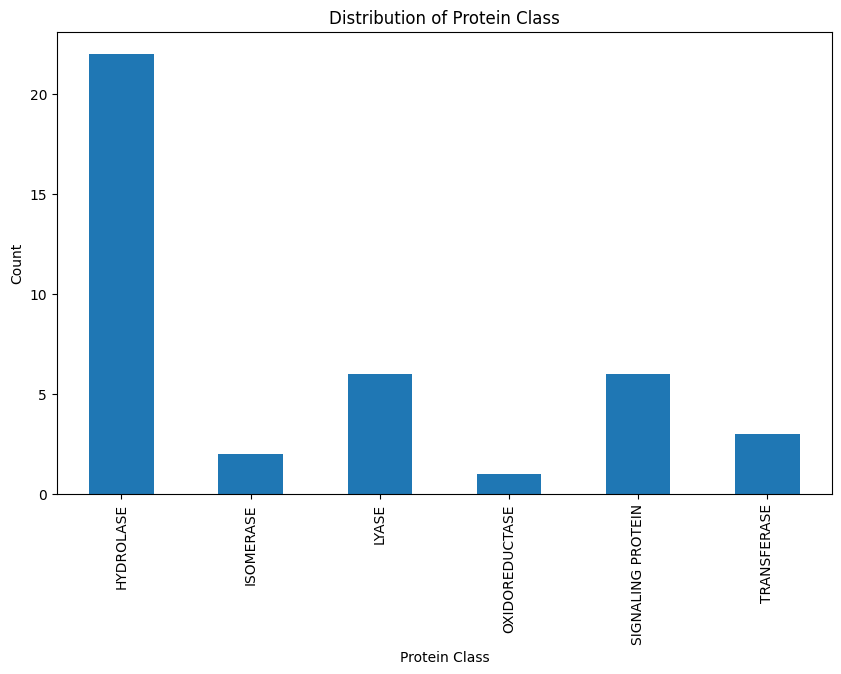

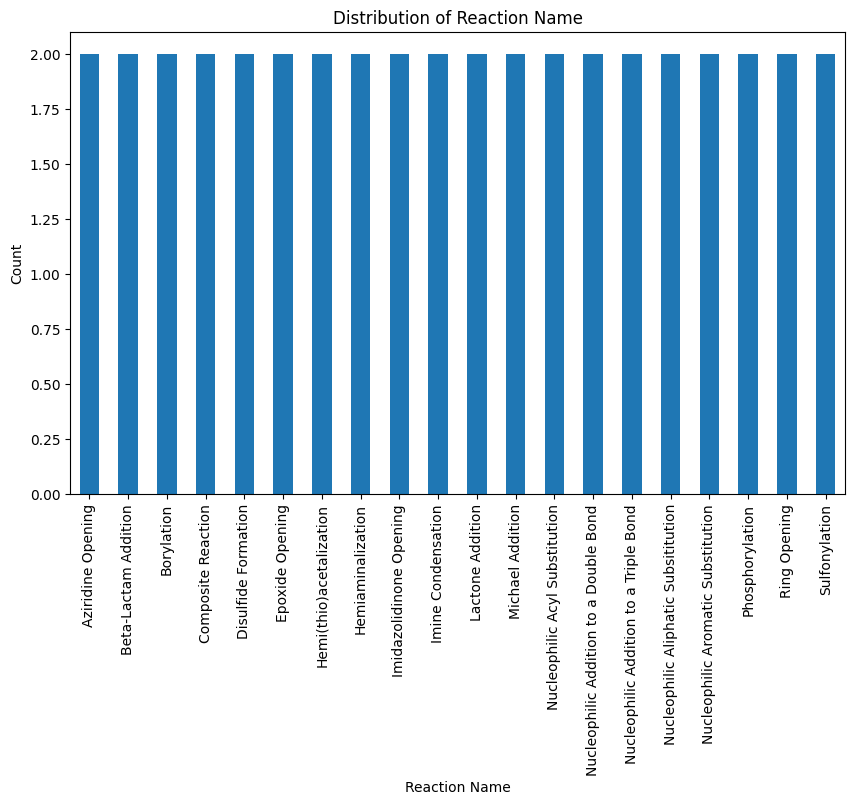

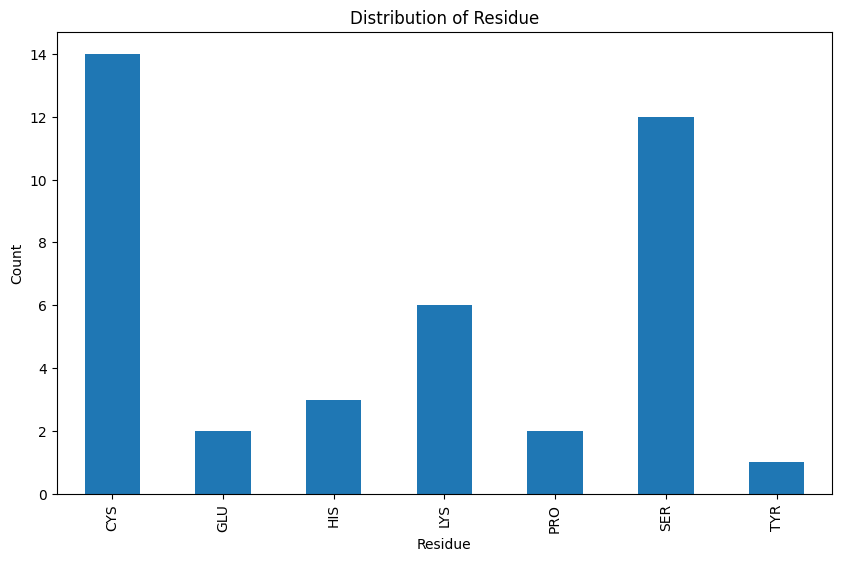

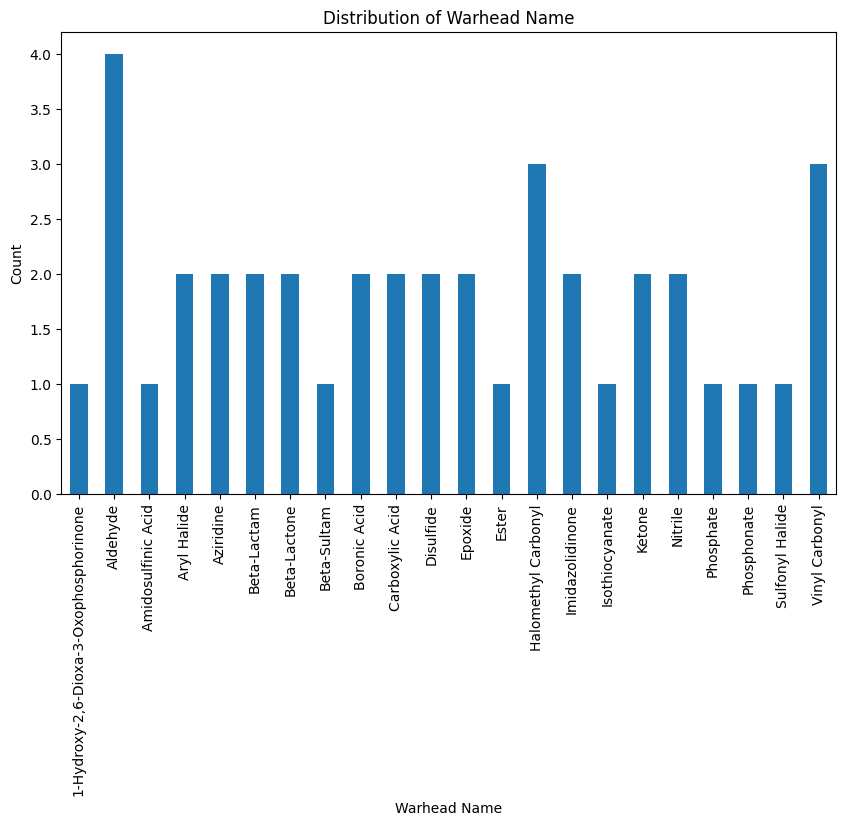

In [47]:
# Function to plot the count of specific values in each column
values_to_plot = ['Reaction Name','Warhead Name','Protein Class','Residue']
def plot_value_counts(df, values_to_plot):
    for column in df.columns:
        if column in values_to_plot:
            plt.figure(figsize=(10, 6))
            if column == 'Residue':
                df[column].str.split().str[0].value_counts().sort_index().plot(kind='bar')
            else:
                df[column].value_counts().sort_index().plot(kind='bar')
            plt.title(f'Distribution of {column}')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.show()

print("Distrubiton Plots for Selected Dataset")
plot_value_counts(highest_res_samples, values_to_plot)